<a href="https://colab.research.google.com/github/Nmg1994/Beehive_habitat_suitability/blob/main/Beehive_habitat_suitability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary modules

In [ ]:
!pip install scikit-survival pdpbox matplotlib
!pip install tqdm
!pip install randomSurvivalForest
!pip install rasterio
!pip install lifelines

# Importing necessary libraries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import (
    concordance_index_censored,
    integrated_brier_score
)

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sklearn.inspection import permutation_importance
import rasterio
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d
import glob
from sklearn.preprocessing import KBinsDiscretizer
import statsmodels.api as sm
from lifelines import CoxTimeVaryingFitter

# Mounting Google Drive

In [3]:
# Mounting Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Formatting air quality data appropriately for further processing in ArcGIS Pro

In [ ]:
Stations = pd.read_csv("/content/drive/My Drive/Air quality data/liste-des-stations-rsqa.csv")

for y in range(2017, 2022):
  air_quality = pd.read_csv(f"/content/drive/My Drive/Air quality data/rsqa-multi-polluants{y}.csv", low_memory=False)
  Date_column = air_quality.filter(regex='DATE').columns.tolist()[0]

  # Filter for rows where the date string starts with the target months
  filtered_df = air_quality[air_quality[Date_column].str.contains(f'{y}-05|{y}-06|{y}-07|{y}-08', regex=True, na=False)]

  stations = filtered_df['NO_POSTE'].unique()

  All_stations = pd.DataFrame(columns=['Station', 'latitude', 'longitude','PM2,5_'+str(y), 'O3_'+str(y)])

  i = 1
  for station in stations:
    each_station_AirQuality = filtered_df[filtered_df['NO_POSTE'] == station][['PM2,5','O3']].apply(pd.to_numeric, errors='coerce')
    All_stations.loc[i,'Station'] = station
    All_stations.loc[i,'latitude'] = Stations[Stations['numero_station'] == station]['latitude'].iloc[0]
    All_stations.loc[i,'longitude'] = Stations[Stations['numero_station'] == station]['longitude'].iloc[0]
    All_stations.loc[i, 'PM2,5_'+str(y)] = each_station_AirQuality.mean(axis = 0)['PM2,5']
    All_stations.loc[i, 'O3_'+str(y)] = each_station_AirQuality.mean(axis = 0)['O3']
    i +=1

  All_stations.to_csv(f"/content/drive/My Drive/Air quality data/Air_Quality_{y}.csv", index=False)

#Formatting climatic data appropriately for further processing in ArcGIS Pro

In [ ]:
stations = True
Months = ['Jan', 'Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct','Nov','Dec']

for yy in range(2017, 2022):
  for month_ind in tqdm(range(5, 9), desc = ''):
    if month_ind < 10:
      month_ind = '0' + str(month_ind)
    else:
      month_ind = str(month_ind)

    if stations == True:
      df = pd.read_csv('/content/drive/My Drive/Montreal_Climate_Urban_Beekeeping/en_climate_summaries_QC_'+ str(month_ind) + f'-{yy}.csv')
      stations_df_columns = ['Stn_Name', 'Long', 'Lat']
      Stations_Qc = df[stations_df_columns]
      stations = False

    df = pd.read_csv('/content/drive/My Drive/Montreal_Climate_Urban_Beekeeping/en_climate_summaries_QC_'+ str(month_ind) + f'-{yy}.csv')

    month_name = Months[int(month_ind) - 1]
    Stations_Qc['Precip_' + month_name]= df['P']
    Stations_Qc['Air avg_' + month_name]= df['Tm']
    Stations_Qc['Air max_' + month_name]= df['Tx']
    Stations_Qc['Air min_' + month_name]= df['Tn']

  if yy == 2017:
    Stations_Qc_modified = pd.DataFrame()
    Stations_Qc_modified['Station'] = Stations_Qc['Stn_Name']
    Stations_Qc_modified['Latitude'] = Stations_Qc['Lat']
    Stations_Qc_modified['Longitude'] = Stations_Qc['Long']

  Stations_Qc_modified[f'Precipitation_{yy}'] = (Stations_Qc['Precip_May'] + Stations_Qc['Precip_Jun'] + Stations_Qc['Precip_Jul'] + Stations_Qc['Precip_Aug'])/4
  Stations_Qc_modified[f'Temperature_max_{yy}'] = (Stations_Qc['Air max_May'] + Stations_Qc['Air max_Jun'] + Stations_Qc['Air max_Jul'] + Stations_Qc['Air max_Aug'])/4

Stations_Qc_modified.to_csv('/content/drive/My Drive/Montreal_Climate_Urban_Beekeeping/Meteorological_data_All_years.csv', index= False)

# Preprocessing data

In [ ]:
Montreal_dataset = pd.read_csv("/content/drive/My Drive/COX_RSF_Paper/All_beehives.csv")
Montreal_dataset_2017_2021 = Montreal_dataset[(Montreal_dataset['Year'] != 2022)]
Montreal_dataset_2017_2021_filtered = Montreal_dataset_2017_2021.loc[Montreal_dataset_2017_2021.groupby('ColonyID')['Year'].idxmax()]
Montreal_dataset_cleaned = Montreal_dataset_2017_2021_filtered[['ColonyID','Year','Status','Place','Lat','Lng']].reset_index(drop=True)
Montreal_dataset_cleaned.to_csv('/content/drive/My Drive/COX_RSF_Paper/Preprocessed_Montreal_Beehive_dataset.csv', index=False)

In [ ]:
variables = ['DEM','Proximity to roads','Road density','NDVI','O3', 'PM25','Precipitation','Temperature_max']
buffertype = ['1KmBuffer', '3KmBuffer']

for buffer in buffertype:
  variables_df = pd.DataFrame()
  for var in variables:
    all_files = glob.glob('/content/drive/My Drive/COX_RSF_Paper/*.xls')

    if var == 'Proximity to roads' or var == 'Road density' or var == 'DEM':
      selected_files = [file for file in all_files if ((f"{var}" in file) and (f"{buffer}" in file)) ]
      for file in selected_files:
          df = pd.read_excel(file)
          preprocessed_df = df[['ColonyID','MEAN']].rename(columns={'MEAN': f'{var}'})
          variables_df = pd.concat([variables_df, preprocessed_df], axis = 1)
    else:
      for yy in range(2017, 2022):
        selected_files = [file for file in all_files if ((f"{var}" in file) and (f"{yy}" in file) and (f"{buffer}" in file)) ]

        for file in selected_files:
            df = pd.read_excel(file)
            preprocessed_df = df[['ColonyID','MEAN']].rename(columns={'MEAN': f'{var}_{yy}'})
            variables_df = pd.concat([variables_df, preprocessed_df], axis = 1)

  variables_df = variables_df.loc[:, ~variables_df.columns.duplicated()]
  variables_df.to_csv(f'/content/drive/My Drive/COX_RSF_Paper/variables_excep_LandC_{buffer}.csv', index=False)

In [ ]:
for buffer in buffertype:
  variables_df = pd.read_csv(f'/content/drive/My Drive/COX_RSF_Paper/variables_excep_LandC_{buffer}.csv')
  LandCover_all_years= pd.DataFrame()

  for y in range(2017, 2022):
    df = pd.read_excel(f"/content/drive/My Drive/COX_RSF_Paper/CropType_{y}_{buffer}.xls")
    df = df.drop(columns= ['OBJECTID']).reset_index(drop=True)

    Desired_croptypes = ['BUCKWHEAT', 'FLAXSEED', 'SOYBEANS', 'PEAS', 'BEANS', 'OTHER VEGETABLES',
                         'BLUEBERRY', 'CRANBERRY', 'OTHER BERRY', 'ORCHARDS', 'OTHER FRUITS','PASTURE/FORAGES', 'FALLOW',
                         'OTHER CROPS']
    croptypes_df = pd.DataFrame()

    for croptype in Desired_croptypes:
      if croptype in df.columns:
        croptypes_df[croptype] = df[croptype].copy()
    # Variety of crop types
    croptypes_df[f'Crop types_{y}'] = (croptypes_df > 0).sum(axis=1)
    LandCover_all_years = pd.concat([LandCover_all_years, croptypes_df[f'Crop types_{y}']], axis = 1)

    df['Sum'] = df[['WINTER_WHEAT', 'SPRING_WHEAT', 'SOYBEANS',
          'CORN', 'PASTURE_FORAGES', 'GREENHOUSES', 'WETLAND', 'WATER',
          'SHRUBLAND', 'CONIFEROUS', 'BROADLEAF', 'MIXEDWOOD', 'URBAN_DEVELOPED',
          'EXPOSED_LAND_BARREN']].sum(axis = 1)

    columns_to_divide = ['WINTER_WHEAT', 'SPRING_WHEAT', 'SOYBEANS',
          'CORN', 'PASTURE_FORAGES', 'GREENHOUSES', 'WETLAND', 'WATER',
          'SHRUBLAND', 'CONIFEROUS', 'BROADLEAF', 'MIXEDWOOD', 'URBAN_DEVELOPED',
          'EXPOSED_LAND_BARREN']

    df[columns_to_divide] = df[columns_to_divide].div(df['Sum'], axis=0)

    Preprocessed_landC_df = df[['COLONYID','WATER','URBAN_DEVELOPED']].rename(columns={'COLONYID': 'ColonyID', 'WATER': f'Percentage of water_{y}', 'URBAN_DEVELOPED': f'Percentage of urban areas_{y}'})
    LandCover_all_years = pd.concat([LandCover_all_years, Preprocessed_landC_df], axis = 1)

  LandCover_all_years = LandCover_all_years.loc[:, ~LandCover_all_years.columns.duplicated()]
  LandCover_all_years.to_csv(f'/content/drive/My Drive/COX_RSF_Paper/LandCover_all_years_{buffer}.csv', index=False)

  All_variables = pd.merge(variables_df, LandCover_all_years, on='ColonyID', how='inner')
  All_variables.to_csv(f'/content/drive/My Drive/COX_RSF_Paper/All_variables_{buffer}.csv', index=False)

In [ ]:
for buffer in buffertype:
  All_variables = pd.read_csv(f'/content/drive/My Drive/COX_RSF_Paper/All_variables_{buffer}.csv')
  beehive_dataset = pd.read_excel(f"/content/drive/My Drive/COX_RSF_Paper/SurrHives_{buffer}.xls")

  beehive_dataset_cleaned = beehive_dataset[['Join_Count','ColonyID','Year','Status']].reset_index(drop=True)

  beehive_dataset_cleaned.loc[beehive_dataset_cleaned['Status'] == 'Dead', 'event']=1
  beehive_dataset_cleaned.loc[beehive_dataset_cleaned['Status'] == 'Healthy', 'event']=0
  beehive_dataset_cleaned['event'] = beehive_dataset_cleaned['event'].astype(int)

  beehive_dataset_cleaned['Year'] = beehive_dataset_cleaned['Year'] - 2016 # assuming that the year 2017 is the first year of beehive creation; in other words, the age of the beehive is considered since the year 2017
  beehive_dataset_cleaned['Year'] = beehive_dataset_cleaned['Year'].astype(int)
  beehive_dataset_cleaned = beehive_dataset_cleaned.rename(columns={'Join_Count': 'Surrounding hive count', 'Year':'time'})
  Montreal_Beehive_df = beehive_dataset_cleaned.drop(columns= ['Status']).reset_index(drop=True)
  Montreal_Beehive_df.to_csv(f'/content/drive/My Drive/COX_RSF_Paper/Preprocessed_Beehive_dataset_{buffer}.csv', index=False)
  pd.merge(Montreal_Beehive_df, All_variables, on='ColonyID', how='inner').to_csv(f'/content/drive/My Drive/COX_RSF_Paper/Preprocessed_Beehive_dataset_with_variables_{buffer}.csv', index=False)

In [ ]:
for buffer in buffertype:
  Preprocessed_Beehive_dataset_with_variables = pd.read_csv(f"/content/drive/My Drive/COX_RSF_Paper/Preprocessed_Beehive_dataset_with_variables_{buffer}.csv")
  Base_df = Preprocessed_Beehive_dataset_with_variables[['Surrounding hive count','ColonyID','time','event','DEM','Proximity to roads','Road density']].copy()

  Final_preprocessed_df = pd.DataFrame()

  # Loop through the years and process data
  for y in range(2017, 2022):
      Base_df['Year'] = y
      # Find columns containing the year
      annual_columns = Preprocessed_Beehive_dataset_with_variables.filter(regex=f'{y}').columns.tolist()
      annual_df = Preprocessed_Beehive_dataset_with_variables[annual_columns].copy()
      annual_df.columns = annual_df.columns.str.replace(f'{y}', '', regex=True)
      annual_df.columns = annual_df.columns.str.replace('_', '', regex=False)
      annual_df.columns = annual_df.columns.str.replace('Temperaturemax', 'Maximum temperature', regex=False)

      temp_df = pd.concat([Base_df.reset_index(drop=True), annual_df.reset_index(drop=True)], axis=1)
      Final_preprocessed_df = pd.concat([Final_preprocessed_df, temp_df], axis=0, ignore_index=True)

  # Save the final preprocessed DataFrame to a CSV file
  Final_preprocessed_df.to_csv(f'/content/drive/My Drive/COX_RSF_Paper/Final_preprocessed_df_{buffer}.csv', index=False)

# Spearman correlation and multi-collinearity analyses

Buffer: 1KmBuffer
Highly correlated pairs (ρ > 0.85): []


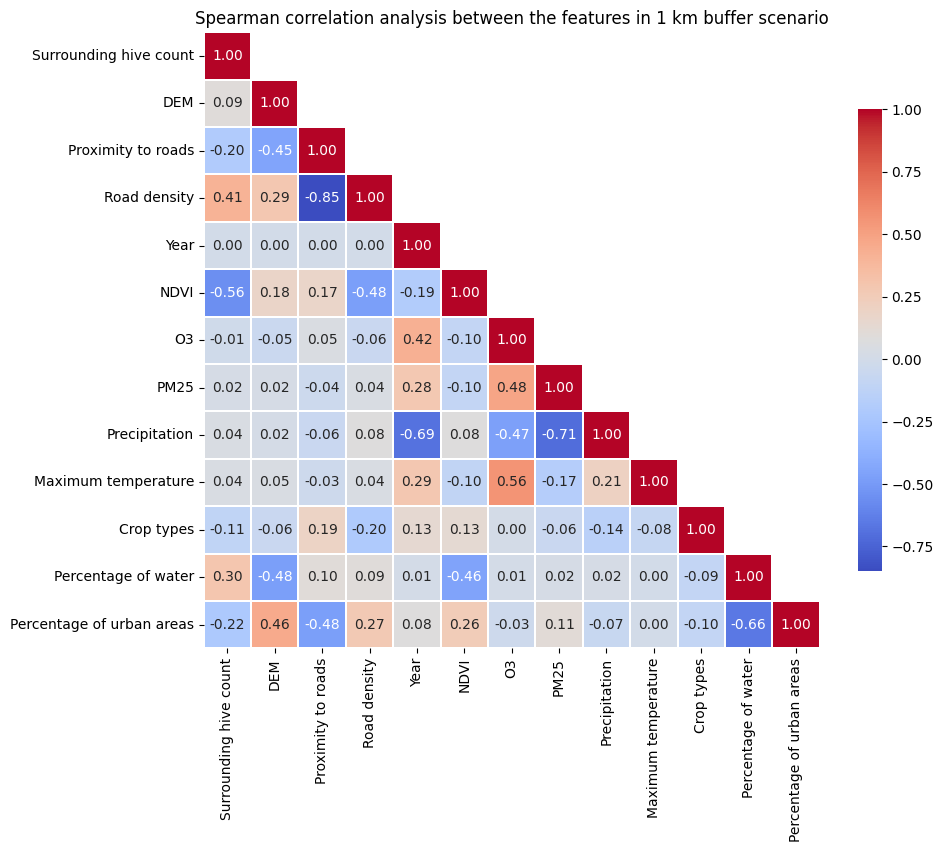

VIF evaluation
                      Feature  VIF  Tolerance
0      Surrounding hive count    2   0.610062
1                         DEM    1   0.715094
2          Proximity to roads    4   0.226702
3                Road density    5   0.194727
4                        Year    8   0.121803
5                        NDVI    2   0.405314
6                          O3    6   0.164681
7                        PM25    2   0.439965
8               Precipitation   17   0.057167
9         Maximum temperature    8   0.118530
10                 Crop types    1   0.858154
11        Percentage of water    4   0.281645
12  Percentage of urban areas    4   0.262226
Buffer: 3KmBuffer
Highly correlated pairs (ρ > 0.85): [('Percentage of urban areas', 'Percentage of water')]


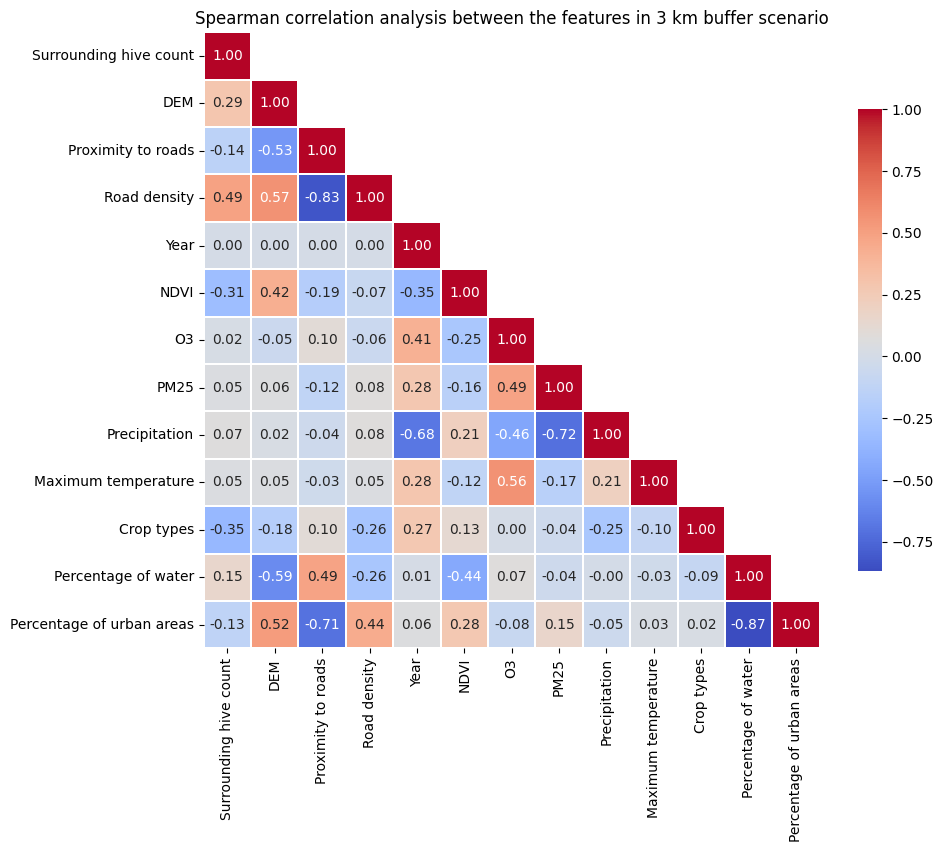

VIF evaluation
                      Feature  VIF  Tolerance
0      Surrounding hive count    2   0.478379
1                         DEM    3   0.384536
2          Proximity to roads    5   0.211480
3                Road density    5   0.199149
4                        Year   10   0.099167
5                        NDVI    4   0.283025
6                          O3    8   0.126637
7                        PM25    3   0.373365
8               Precipitation   21   0.048050
9         Maximum temperature   11   0.094714
10                 Crop types    2   0.634703
11        Percentage of water   14   0.070167
12  Percentage of urban areas   12   0.083688


In [ ]:
# Calculating VIF and Tolerance
def calculate_vif(df):
  # Adding a constant column for the intercept
  df_with_constant = sm.add_constant(df)

  # Calculating VIF for each feature
  vif_data = pd.DataFrame()
  vif_data['Feature'] = df.columns
  vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i+1) for i in range(len(df.columns))]
  vif_data['Tolerance'] = 1 / vif_data['VIF']

  return vif_data

buffertype = ['1KmBuffer', '3KmBuffer']
for buffer in buffertype:
  print(f'Buffer: {buffer}')
  Final_preprocessed_df = pd.read_csv(f'/content/drive/My Drive/COX_RSF_Paper/Final_preprocessed_df_{buffer}.csv')
  # Calculate the correlation matrix
  Features = Final_preprocessed_df.drop(columns= ['ColonyID','event', 'time'])
  # Calculating the Spearman correlation matrix
  corr_matrix = Features.corr(method='spearman', numeric_only=True)
  corr = corr_matrix.abs()
  # Select upper triangle of correlation matrix
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

  # Find pairs with correlation > 0.85
  high_corr = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > 0.85]

  print("Highly correlated pairs (ρ > 0.85):", high_corr)

  # Masking the upper triangle excluding the diagonal
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
  # Setting up the matplotlib figure
  plt.figure(figsize=(10, 8))

  # Plotting the heatmap with the mask and correct aspect ratio for the variables
  sns.heatmap(corr_matrix,  annot = True, mask=mask, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": 0.75}, linewidths=0.1)
  if buffer == '1KmBuffer':
    plt.title('Spearman correlation analysis between the features in 1 km buffer scenario')
  else:
    plt.title('Spearman correlation analysis between the features in 3 km buffer scenario')
  plt.show()
  # Using the function to calculate VIF and Tolerance
  VIF = calculate_vif(Features)
  # Converting to integer format
  VIF["VIF"] = VIF["VIF"].apply(lambda x: int(round(x)))
  print('VIF evaluation')
  print(VIF)

  features_high_vif = VIF[VIF['VIF'] >= 5]
  if buffer == '1KmBuffer':
    columns_to_drop_1Km_buffer = np.array(features_high_vif['Feature'])
  else:
    columns_to_drop_3Km_buffer = np.array(features_high_vif['Feature'])

# Splitting data into training and testing datasets

In [ ]:
Final_preprocessed_df_1Km = pd.read_csv(f'/content/drive/My Drive/COX_RSF_Paper/Final_preprocessed_df_1KmBuffer.csv')
Final_preprocessed_df_3Km = pd.read_csv(f'/content/drive/My Drive/COX_RSF_Paper/Final_preprocessed_df_3KmBuffer.csv')

In [ ]:
#Splitting datasets after dropping the features with the VIF value more than 10
def splitting_data(dataframe, columns_to_drop):
  columns_to_drop_all = np.concatenate((columns_to_drop , np.array(['ColonyID', 'event', 'time'])), axis = 0)
  Considered_features = [col for col in dataframe.columns if col not in columns_to_drop_all]
  print('Considered_features: ', Considered_features)

  X = np.array(dataframe.drop(columns= columns_to_drop_all))

  # Structured array of target variable
  Y = Surv.from_arrays(dataframe['event'], dataframe['time'])  # survival outcome (event and time)

  # Initial split: Training and Testing datasets (70:30)
  X_training, X_testing, Y_training, Y_testing = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=0)

  # Shape of datasets
  print('X_training shape: ', X_training.shape)
  print('Y_training shape: ', Y_training.shape)
  print('X_testing shape: ', X_testing.shape)
  print('Y_testing shape: ', Y_testing.shape)

  return X_training, X_testing, Y_training, Y_testing, Considered_features, X, Y

In [ ]:
# Applying splitting_data function to split training dataset from testing
X_training_1Km, X_testing_1Km, Y_training_1Km, Y_testing_1Km, Considered_features_1Km, X_total_1Km, Y_total_1Km= splitting_data(Final_preprocessed_df_1Km, columns_to_drop_1Km_buffer)
X_training_3Km, X_testing_3Km, Y_training_3Km, Y_testing_3Km, Considered_features_3Km, X_total_3Km, Y_total_3Km= splitting_data(Final_preprocessed_df_3Km, columns_to_drop_3Km_buffer)

Considered_features:  ['Surrounding hive count', 'DEM', 'Proximity to roads', 'NDVI', 'PM25', 'Crop types', 'Percentage of water', 'Percentage of urban areas']
X_training shape:  (3682, 8)
Y_training shape:  (3682,)
X_testing shape:  (1578, 8)
Y_testing shape:  (1578,)
Considered_features:  ['Surrounding hive count', 'DEM', 'NDVI', 'PM25', 'Crop types']
X_training shape:  (3682, 5)
Y_training shape:  (3682,)
X_testing shape:  (1578, 5)
Y_testing shape:  (1578,)


# Training RSF and Cox models and evaluating their accuracy

RSF Model

In [ ]:
# Optimizing hyper-parameters for the RSF for the 1 Km buffer scenario
parameters = {'n_estimators':np.arange(100,500,50), 'max_depth':np.arange(1,30,4)}
RSF_1Km = RandomSurvivalForest(random_state=0, bootstrap = True)
RSF_model_gs_1Km = GridSearchCV(RSF_1Km, parameters, cv=5, return_train_score=True, n_jobs=-1)
RSF_model_gs_1Km.fit(X_training_1Km, Y_training_1Km)
RSF_model_gs_1Km.best_params_

# Printing the best hyperparameters found
print("Best hyperparameters:", RSF_model_gs_1Km.best_params_)
print("\n")

# Printing the best cross-validated score
print("Best cross-validated score (concordance index):", RSF_model_gs_1Km.best_score_)

In [ ]:
# Fitting a RSF model to the training dataset having found the optimized values for the hyper-parameters
# the configuration including beehive management criteria
RSF_model_1Km = RandomSurvivalForest(random_state=0, n_estimators = 450, max_depth = 29, bootstrap = True)
RSF_model_1Km.fit(X_training_1Km, Y_training_1Km)

RandomSurvivalForest(max_depth=29, n_estimators=450, random_state=0)

In [ ]:
# Optimizing hyper-parameters for the RSF for the 3 Km buffer scenario
parameters = {'n_estimators':np.arange(100,500,50), 'max_depth':np.arange(1,30,4)}
RSF_3Km = RandomSurvivalForest(random_state=0, bootstrap = True)
RSF_model_gs_3Km = GridSearchCV(RSF_3Km, parameters, cv=5, return_train_score=True, n_jobs=-1)
RSF_model_gs_3Km.fit(X_training_3Km, Y_training_3Km)
RSF_model_gs_3Km.best_params_

# Printing the best hyperparameters found
print("Best hyperparameters:", RSF_model_gs_3Km.best_params_)
print("\n")

# Printing the best cross-validated score
print("Best cross-validated score (concordance index):", RSF_model_gs_3Km.best_score_)

In [ ]:
# Fitting a RSF model to the training dataset having found the optimized values for the hyper-parameters
# the configuration including beehive management criteria
RSF_model_3Km = RandomSurvivalForest(random_state=0, n_estimators = 450, max_depth = 29, bootstrap = True)
RSF_model_3Km.fit(X_training_3Km, Y_training_3Km)

RandomSurvivalForest(max_depth=29, n_estimators=450, random_state=0)

Cox model

In [ ]:
# Fitting a Cox Proportional Hazards model to the training dataset for the 1Km scenario
cox_model_1Km = CoxPHSurvivalAnalysis()
cox_model_1Km.fit(X_training_1Km, Y_training_1Km)

CoxPHSurvivalAnalysis()

In [ ]:
# Fitting a Cox Proportional Hazards model to the training dataset for the 3Km scenario
cox_model_3Km = CoxPHSurvivalAnalysis()
cox_model_3Km.fit(X_training_3Km, Y_training_3Km)

CoxPHSurvivalAnalysis()

Evaluation of models' accuracy

In [ ]:
# RSF model
def calibrate_rsf_model(rsf_model, X_training, Y_training):
  # Predicting survival probabilities on the training data
  pred_surv_probs = rsf_model.predict_survival_function(X_training, return_array=True)

  # Preparing the true survival probabilities for calibration
  Y_training_real = Surv.from_arrays(event=Y_training['event'], time=Y_training['time'])
  unique_times_real = np.unique(Y_training['time'])
  mean_true_surv_probs = np.array([np.mean(Y_training['time'] >= t) for t in unique_times_real])

  # Interpolating predicted probabilities to align with the true survival times
  interp_func = interp1d(rsf_model.unique_times_, np.mean(pred_surv_probs, axis=0), kind='nearest', fill_value='extrapolate')
  pred_surv_probs_interp = interp_func(unique_times_real)

  # Applying Isotonic regression for calibration
  iso_reg = IsotonicRegression(out_of_bounds='clip')
  iso_reg.fit(pred_surv_probs_interp, mean_true_surv_probs)
  calibrated_pred_surv_probs = iso_reg.transform(pred_surv_probs_interp)

  return calibrated_pred_surv_probs, unique_times_real

def evaluation_rsf_model(model, X_train, X_test, Y_train, Y_test):
  # Calibrating the model using the training set
  calibrated_pred_surv_probs, unique_times_real = calibrate_rsf_model(model, X_train, Y_train)

  # Calculating the Concordance index (C-index)
  c_index = concordance_index_censored(Y_test["event"], Y_test["time"], model.predict(X_test))
  print("Concordance index (C-index):", c_index[0])

  # Getting the probability of event-free survival for the testing dataset
  surv_funcs = model.predict_survival_function(X_test)


  # Finding the range of follow-up times in Y_test
  min_time_test = int(Y_test['time'].min())
  max_time_test = int(Y_test['time'].max())

  # Ensuring times align with follow-up range
  times = np.array([t for t in model.unique_times_ if min_time_test <= t < max_time_test])
  preds = np.array([[fn(t) for t in times] for fn in surv_funcs])

  # Computing the integrated Brier score (IBS) using calibrated probabilities
  ibs = integrated_brier_score(Y_train, Y_test, preds, times)
  print("Integrated Brier Score (IBS):", ibs)


# Cox model
def calibrate_cox_model(cox_model, X_training, Y_training):

    # Predicting survival functions for training data
    surv_funcs = cox_model.predict_survival_function(X_training)
    unique_times_real = np.unique(Y_training["time"])

    # Calculating mean predicted survival probabilities at unique times
    pred_surv_probs = np.array([[fn(t) for t in unique_times_real] for fn in surv_funcs])
    mean_pred_surv_probs = pred_surv_probs.mean(axis=0)

    # Preparing the true survival probabilities for calibration
    mean_true_surv_probs = np.array([np.mean(Y_training["time"] >= t) for t in unique_times_real])

    # Applying Isotonic regression for calibration
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(mean_pred_surv_probs, mean_true_surv_probs)
    calibrated_pred_surv_probs = iso_reg.transform(mean_pred_surv_probs)

    return calibrated_pred_surv_probs, unique_times_real


def evaluation_cox_model(cox_model, X_train, X_test, Y_train, Y_test):
    # Calibrating the Cox model
    calibrated_pred_surv_probs, unique_times_real = calibrate_cox_model(cox_model, X_train, Y_train)

    # Concordance Index (C-index)
    c_index = concordance_index_censored(Y_test["event"], Y_test["time"], cox_model.predict(X_test))
    print("Concordance Index (C-index):", c_index[0])

    # Predicting survival functions for test data
    surv_funcs = cox_model.predict_survival_function(X_test)

    # Range of follow-up times in Y_test
    min_time_test = int(Y_test["time"].min())
    max_time_test = int(Y_test["time"].max())

    # Ensuring times align with follow-up range
    times = np.array([t for t in cox_model.unique_times_ if min_time_test <= t < max_time_test])
    preds = np.array([[fn(t) for t in times] for fn in surv_funcs])

    # Computing the integrated Brier score (IBS) using calibrated probabilities
    ibs = integrated_brier_score(Y_train, Y_test, preds, times)
    print("Integrated Brier Score (IBS):", ibs)

Model evaluation results on both training and test datasets

In [ ]:
# Accuracy on the training and test dataset
# 1Km scenario
# Using the RSF model
print('1 Km scenario')
print("Accuracy of the RSF model on the training dataset, 1Km scenario")
evaluation_rsf_model(model = RSF_model_1Km, X_train = X_training_1Km, X_test = X_training_1Km, Y_train = Y_training_1Km, Y_test = Y_training_1Km)
print("\nAccuracy of the RSF model on the test dataset, 1Km scenario")
evaluation_rsf_model(model = RSF_model_1Km, X_train = X_training_1Km, X_test = X_testing_1Km, Y_train = Y_training_1Km, Y_test = Y_testing_1Km)

# Using the Cox model
print("\nAccuracy of the Cox model on the training dataset, 1Km scenario")
evaluation_cox_model(cox_model = cox_model_1Km, X_train = X_training_1Km, X_test = X_training_1Km, Y_train = Y_training_1Km, Y_test = Y_training_1Km)
print("\nAccuracy of the Cox model on the test dataset, 1Km scenario")
evaluation_cox_model(cox_model = cox_model_1Km, X_train = X_training_1Km, X_test = X_testing_1Km, Y_train = Y_training_1Km, Y_test = Y_testing_1Km)
print("\n")
print('3Km scenario')
print('\n')
# 3Km scenario
# Using the RSF model
print("Accuracy of the RSF model on the training dataset, 3Km scenario")
evaluation_rsf_model(model = RSF_model_3Km, X_train = X_training_3Km, X_test = X_training_3Km, Y_train = Y_training_3Km, Y_test = Y_training_3Km)
print("\nAccuracy of the RSF model on the test dataset, 3Km scenario")
evaluation_rsf_model(model = RSF_model_3Km, X_train = X_training_3Km, X_test = X_testing_3Km, Y_train = Y_training_3Km, Y_test = Y_testing_3Km)

# Using the Cox model
print("\nAccuracy of the Cox model on the training dataset, 3Km scenario")
evaluation_cox_model(cox_model = cox_model_3Km, X_train = X_training_3Km, X_test = X_training_3Km, Y_train = Y_training_3Km, Y_test = Y_training_3Km)
print("\nAccuracy of the Cox model on the test dataset, 3Km scenario")
evaluation_cox_model(cox_model = cox_model_3Km, X_train = X_training_3Km, X_test = X_testing_3Km, Y_train = Y_training_3Km, Y_test = Y_testing_3Km)

1 Km scenario
Accuracy of the RSF model on the training dataset, 1Km scenario
Concordance index (C-index): 0.8966607338550432
Integrated Brier Score (IBS): 0.06603433366104047

Accuracy of the RSF model on the test dataset, 1Km scenario
Concordance index (C-index): 0.8168550736384398
Integrated Brier Score (IBS): 0.10102775649971928

Accuracy of the Cox model on the training dataset, 1Km scenario
Concordance Index (C-index): 0.5631625604687664
Integrated Brier Score (IBS): 0.18967209252828443

Accuracy of the Cox model on the test dataset, 1Km scenario
Concordance Index (C-index): 0.5636165556567385
Integrated Brier Score (IBS): 0.18267065676849356


3Km scenario


Accuracy of the RSF model on the training dataset, 3Km scenario
Concordance index (C-index): 0.9288394073138352
Integrated Brier Score (IBS): 0.04937001340305708

Accuracy of the RSF model on the test dataset, 3Km scenario
Concordance index (C-index): 0.8458294992395383
Integrated Brier Score (IBS): 0.0854099254527827

Accur

# Variable importance assessment

In [ ]:
def feature_importance_evaluation_RSF_model(RSF_model, X, Y, dataframe, scenario):
  # Evaluating feature importance
  result = permutation_importance(RSF_model, X, Y, n_repeats=30)
  feature_importance_df = pd.DataFrame(
      {
          k: result[k]
          for k in ("importances_mean", "importances_std",)
      },
      index=dataframe.columns,
  ).sort_values(by="importances_mean", ascending=False)
  print(feature_importance_df)
  # Plotting error bars
  plt.figure(figsize=(12, 5))
  plt.gca().set_facecolor('white')
  plt.grid(False)

  # Error bars
  plt.errorbar(
      x=feature_importance_df.index,
      y=feature_importance_df['importances_mean'],
      yerr=feature_importance_df['importances_std'],
      fmt='o', markersize=4, capsize=7, color='b', elinewidth=2, label='Mean ± Std Dev'
  )


  plt.xlabel('Variables', fontsize = 12)
  plt.ylabel('Mean importance', fontsize = 12)
  plt.title(f'Importance of variables in {scenario} buffer scenario', fontsize = 14)
  plt.xticks(rotation=45, ha='right', fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.legend(fontsize=12)
  plt.tight_layout()
  plt.show()

  return feature_importance_df

                           importances_mean  importances_std
Surrounding hive count             0.262924         0.004669
Proximity to roads                 0.090334         0.002250
DEM                                0.087326         0.001902
NDVI                               0.038609         0.001410
Percentage of water                0.036433         0.001457
Percentage of urban areas          0.036259         0.001566
PM25                               0.003664         0.000423
Crop types                         0.000502         0.000159


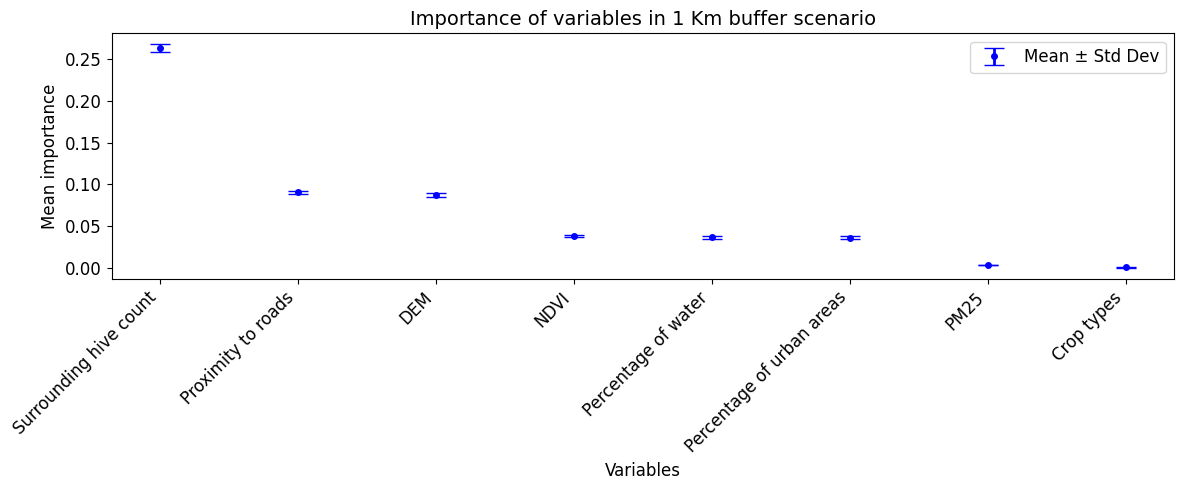

In [ ]:
# Applying the feature_importance_evaluation_RSF_model function in 1Km buffer scenario
feature_importance_df = feature_importance_evaluation_RSF_model(RSF_model = RSF_model_1Km, X = X_total_1Km, Y = Y_total_1Km, dataframe = Final_preprocessed_df_1Km[Considered_features_1Km], scenario= '1 Km')

                        importances_mean  importances_std
Surrounding hive count          0.343036         0.005225
DEM                             0.185535         0.002712
NDVI                            0.077161         0.001733
PM25                            0.021820         0.001038
Crop types                      0.009832         0.000619


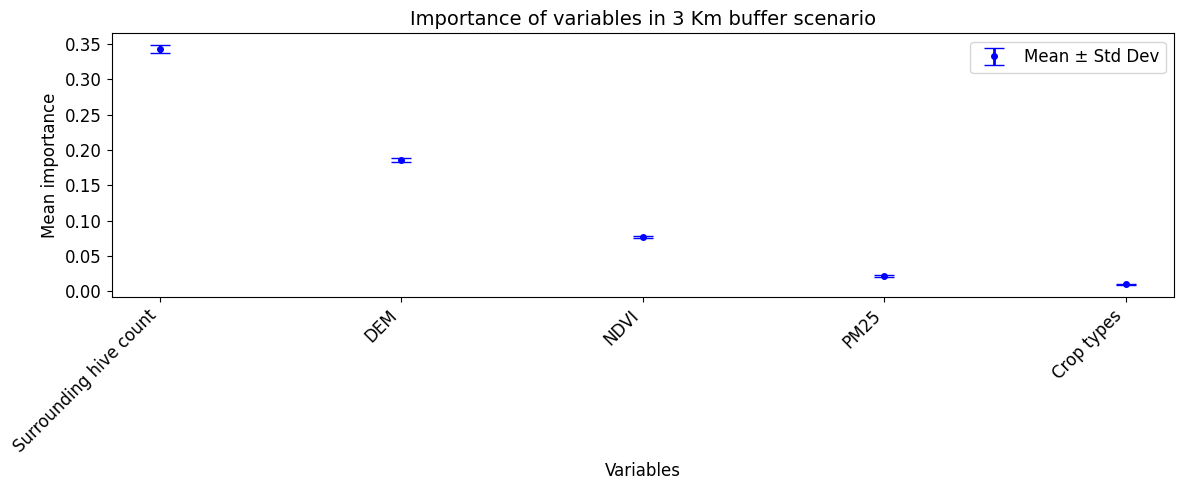

In [ ]:
# Applying the feature_importance_evaluation_RSF_model function in 3Km buffer scenario
feature_importance_df = feature_importance_evaluation_RSF_model(RSF_model = RSF_model_3Km, X = X_total_3Km, Y = Y_total_3Km, dataframe = Final_preprocessed_df_3Km[Considered_features_3Km], scenario = '3 Km')

# Partial dependence plots (PDPs)

In [ ]:
# Function to compute partial dependence
def compute_partial_dependence(model, X, variable, variable_values):
  survival_predictions = []
  event_times = model.predict_survival_function(X.iloc[[0]])[0].x
  for value in variable_values:
    X_temp = X.copy()
    X_temp[variable] = value
    surv_funcs = model.predict_survival_function(X_temp)
    mean_surv = np.mean([sf(event_times) for sf in surv_funcs], axis=0)
    survival_predictions.append(mean_surv)
  return np.array(survival_predictions), event_times

# Function to apply KBinsDiscretizer and print bin edges
def apply_kbins_discretizer(df, variable, n_quantiles=5):
  kbins = KBinsDiscretizer(n_bins=n_quantiles, encode='ordinal', strategy='quantile')
  df.loc[:, variable] = kbins.fit_transform(df[[variable]]).astype(int)
  bin_edges = kbins.bin_edges_[0]
  print(f"Variable: {variable}")
  print(f"Bin edges: {bin_edges}")
  return df, bin_edges

# Function to plot partial dependence
def plotting_partial_dependence(df, Considered_features):

  X = df[Considered_features]
  Y = Surv.from_arrays(df['event'], df['time'])

  # Fitting a Random Survival Forest model
  RSF_model = RandomSurvivalForest(random_state=0, n_estimators= 450, max_depth=29, bootstrap=True)
  RSF_model.fit(X, Y)

  for variable_of_interest in X.columns:
    print(f'{variable_of_interest}')

    unique_vals = sorted(X[variable_of_interest].unique())

    # Binary variable: Hive placement
    if variable_of_interest == 'Crop types':
        variable_values = unique_vals
        bin_labels = {val: f"{val}" for val in variable_values}

    # Continuous variables: use KBinsDiscretizer
    else:
        X, bin_edges = apply_kbins_discretizer(X, variable_of_interest)
        variable_values = np.unique(X[variable_of_interest])
        bin_labels = {idx: f"[{bin_edges[idx]:.2f}, {bin_edges[idx+1]:.2f})"
                      for idx in range(len(bin_edges) - 1)}

    # Compute partial dependence
    partial_dependence, event_times = compute_partial_dependence(
        RSF_model, X, variable_of_interest, variable_values
    )

    # Plotting
    plt.figure(figsize=(10, 6))
    for j, (class_, pdp) in enumerate(zip(variable_values, partial_dependence)):
        label = bin_labels.get(class_, str(class_))
        plt.plot(event_times, pdp, label=f"{variable_of_interest}={label}", linewidth=2)

    plt.xlabel('Time (years)', fontsize=12)
    plt.ylabel('Survival Probability', fontsize=12)
    plt.title(f'Partial Dependence Plot for {variable_of_interest}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.show()


Surrounding hive count
Variable: Surrounding hive count
Bin edges: [ 1.  2.  3.  5.  9. 64.]


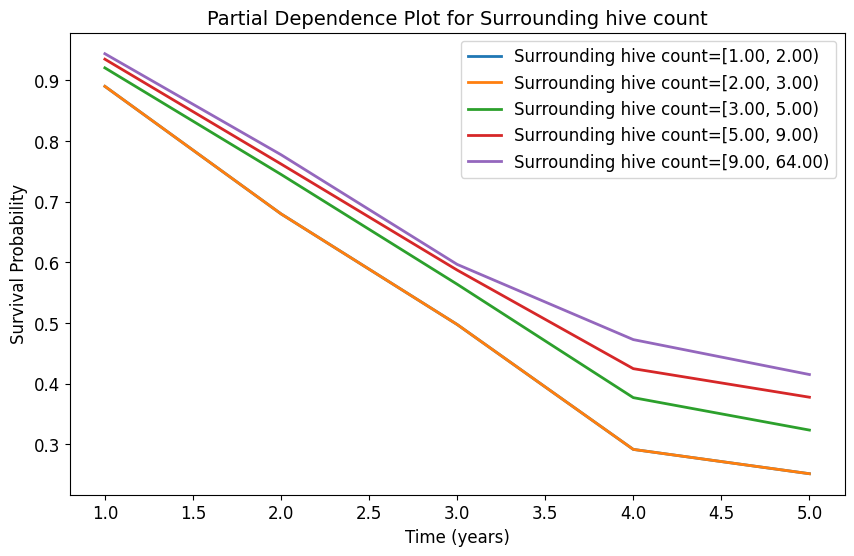

DEM
Variable: DEM
Bin edges: [  6.54967077  23.11270023  31.71117479  42.93785796  54.32639087
 133.25371429]


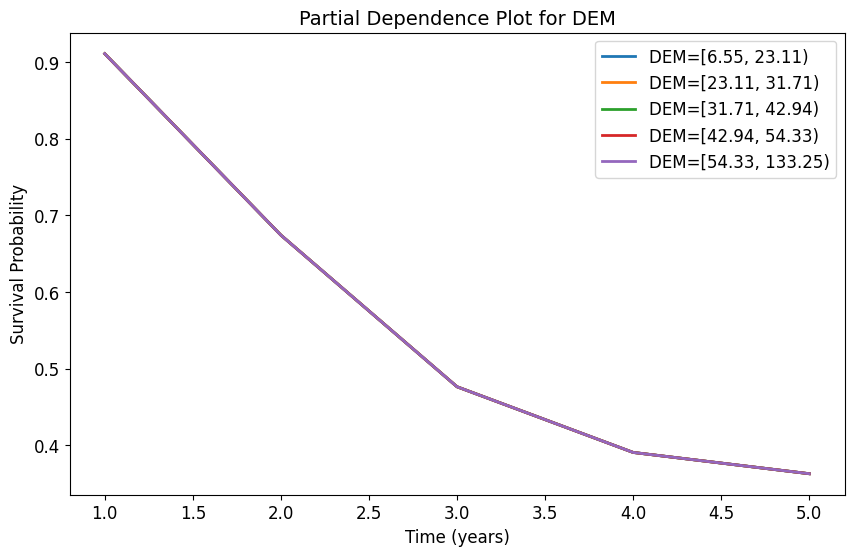

Proximity to roads
Variable: Proximity to roads
Bin edges: [ 20.7513773   30.24303336  35.01545321  57.48778724 100.95837502
 410.3586513 ]


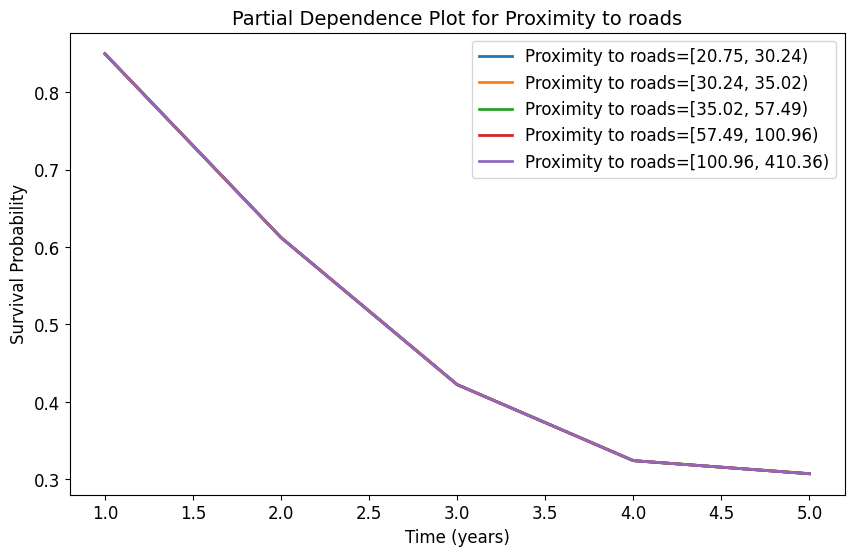

NDVI
Variable: NDVI
Bin edges: [0.05387418 0.08590965 0.1203073  0.14836272 0.18461173 0.38372038]


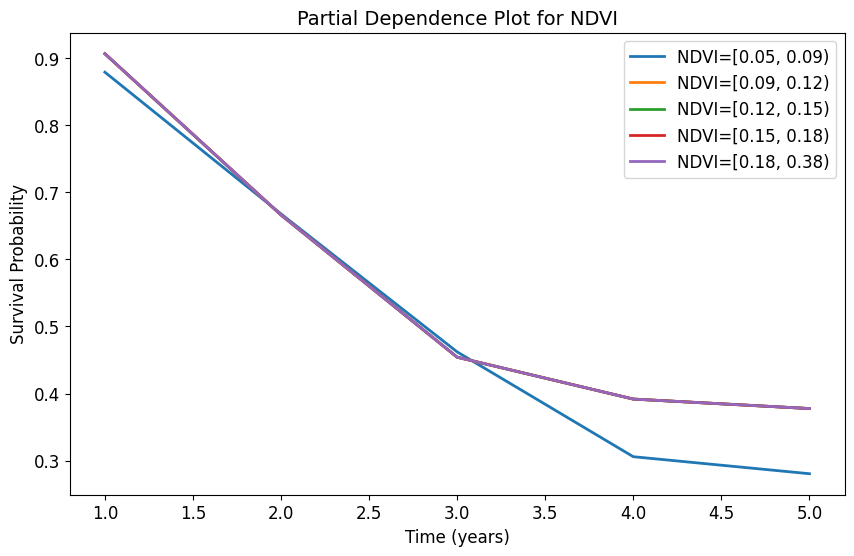

PM25
Variable: PM25
Bin edges: [4.22654265 6.09186595 6.70845027 7.25404705 7.63452371 9.68295486]


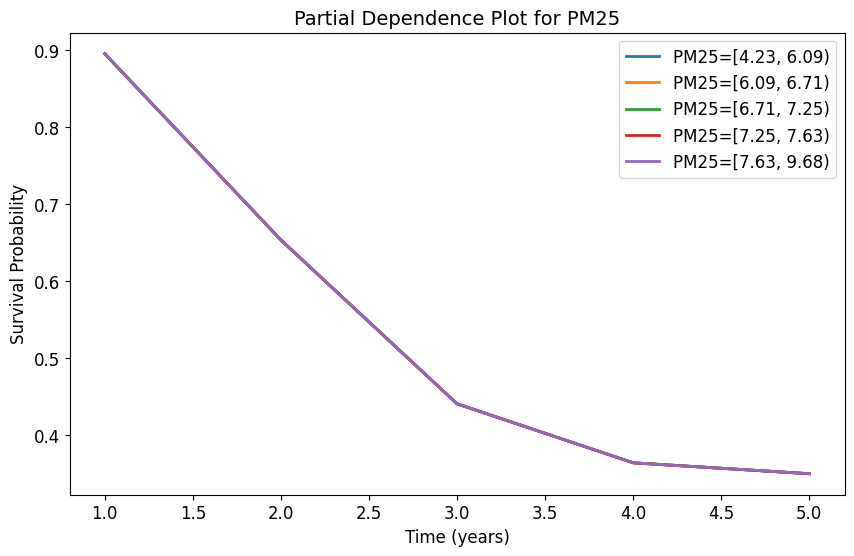

Crop types


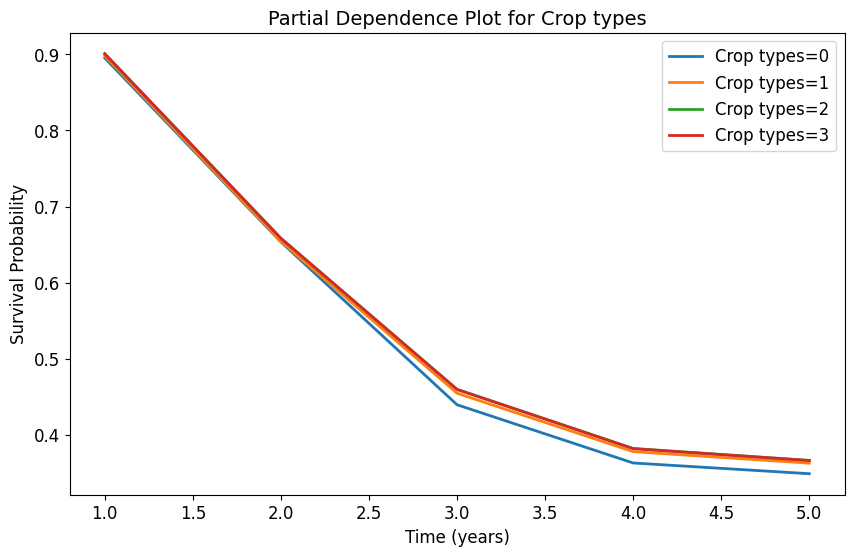

Percentage of water
Variable: Percentage of water
Bin edges: [0.00000000e+00 2.86204923e-04 9.46100917e-03 3.75444307e-02
 6.37274549e-01]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


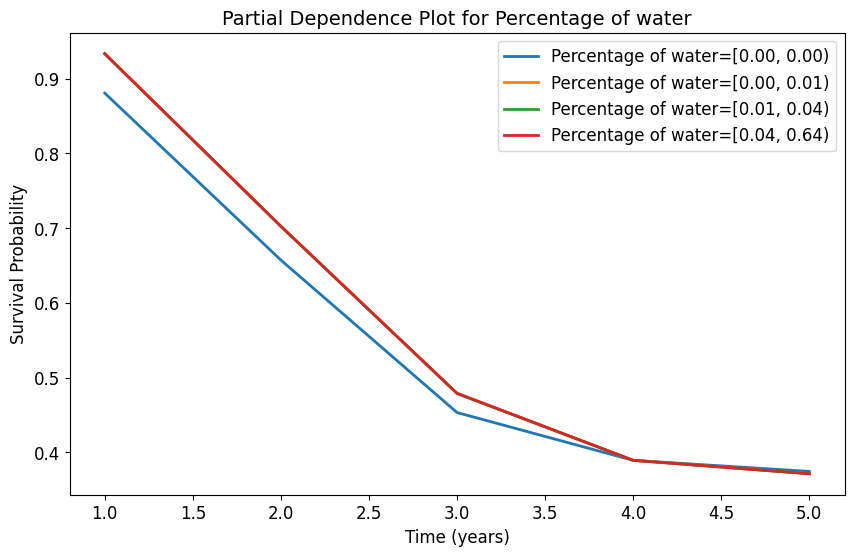

Percentage of urban areas
Variable: Percentage of urban areas
Bin edges: [0.05523755 0.85089921 0.92759429 0.95958727 0.98053807 1.        ]


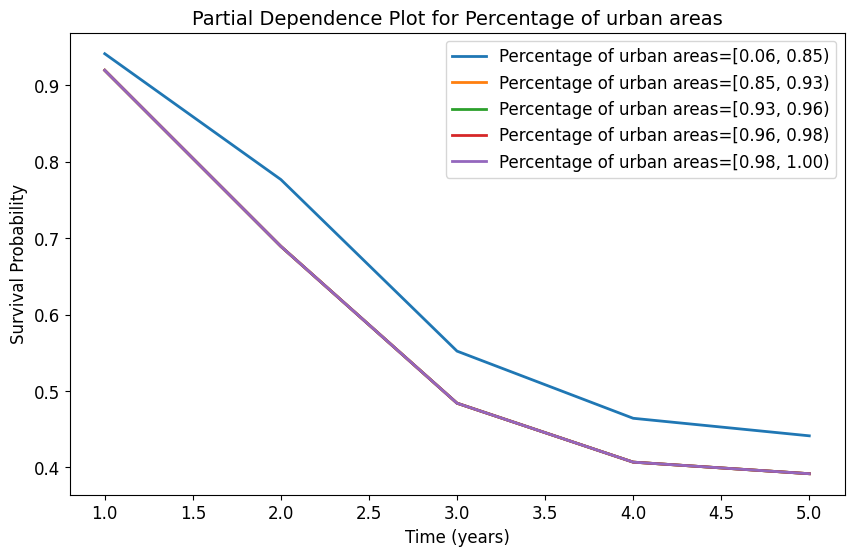

In [ ]:
plotting_partial_dependence(Final_preprocessed_df_1Km, Considered_features_1Km)

Surrounding hive count
Variable: Surrounding hive count
Bin edges: [  1.   5.  10.  19.  51. 121.]


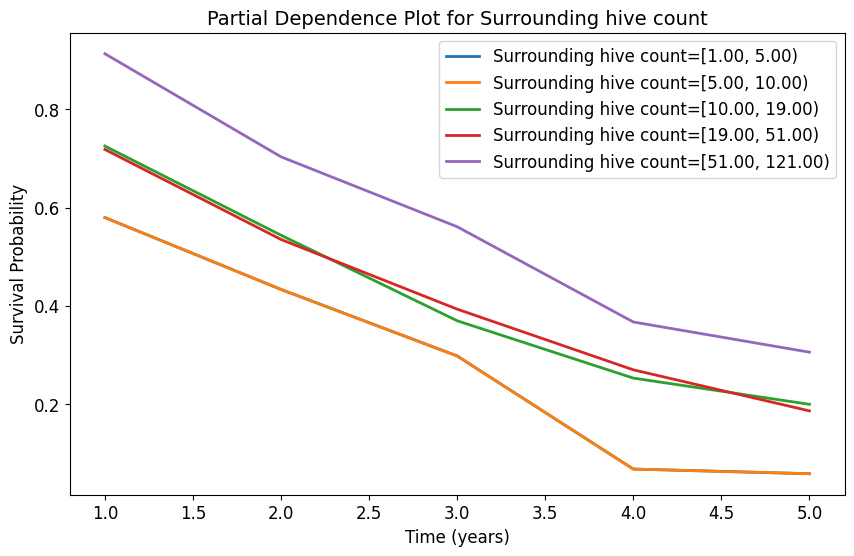

DEM
Variable: DEM
Bin edges: [ 10.06257559  25.73456201  32.15554848  43.22386349  60.05645726
 108.51143166]


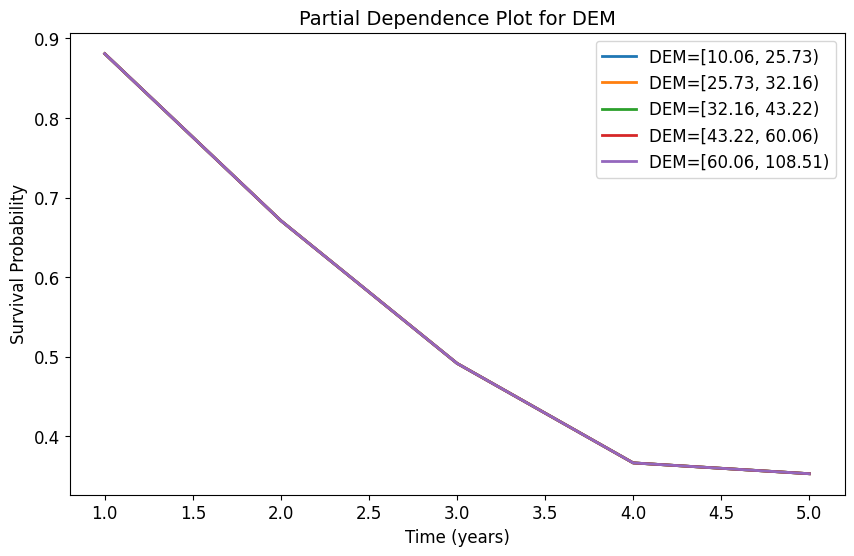

NDVI
Variable: NDVI
Bin edges: [0.05081486 0.11955942 0.14159444 0.15722165 0.17803916 0.36427182]


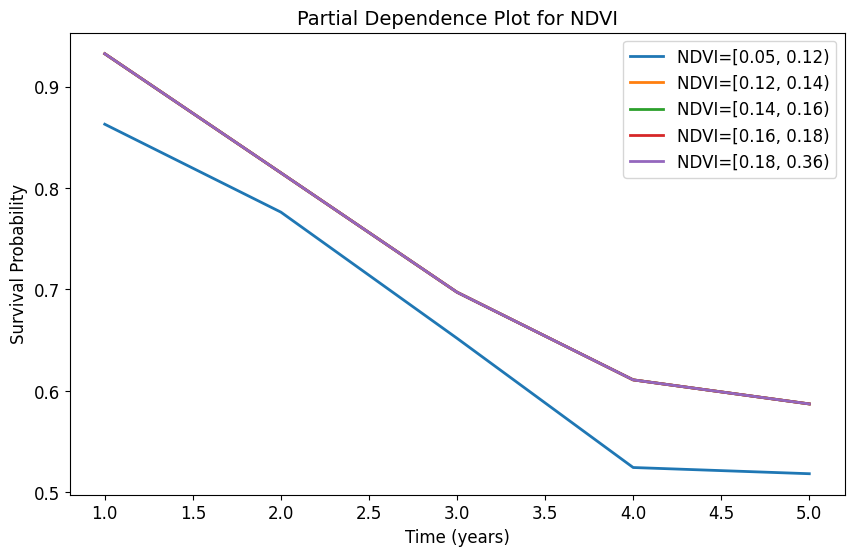

PM25
Variable: PM25
Bin edges: [4.23905949 6.09572001 6.71719558 7.28002396 7.6698509  9.36562675]


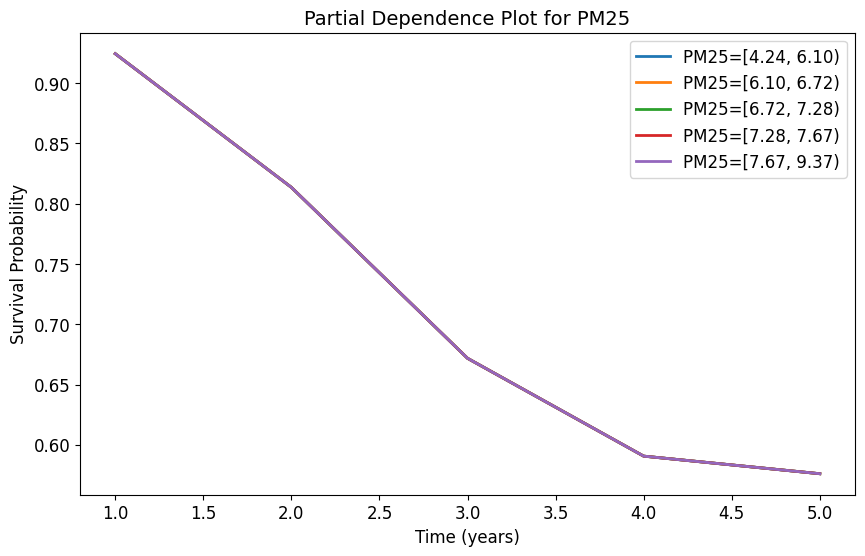

Crop types


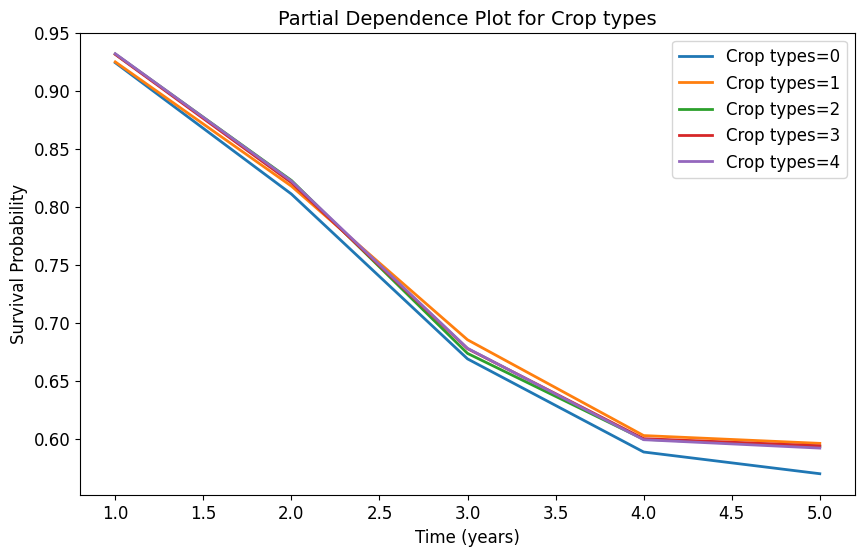

In [ ]:
plotting_partial_dependence(Final_preprocessed_df_3Km, Considered_features_3Km)

# Calculating the survival probability of each pixel in the study area and providing beehive habitat suitability maps

In [ ]:
# Defining raster file paths for the 1 km buffer scenario
raster_paths_1Km = {
    'Road_proximity': '/content/drive/My Drive/COX_RSF_Paper/ProxRoads_masked.tif',
    'DEM': '/content/drive/My Drive/COX_RSF_Paper/DEM_masked.tif',
    'Surrounding_2017_1K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive1K2017.tif',
    'Surrounding_2018_1K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive1K2018.tif',
    'Surrounding_2019_1K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive1K2019.tif',
    'Surrounding_2020_1K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive1K2020.tif',
    'Surrounding_2021_1k': '/content/drive/My Drive/COX_RSF_Paper/SurrHive1K2021.tif'
}


# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

# Reading raster datasets
Road_proximity_data, transform_Road_proximity = read_raster(raster_paths_1Km['Road_proximity'])
DEM_data, transform_DEM = read_raster(raster_paths_1Km['DEM'])
Surrounding_2017_data, transform_Surrounding_2017 = read_raster(raster_paths_1Km['Surrounding_2017_1K'])
Surrounding_2018_data, transform_Surrounding_2018 = read_raster(raster_paths_1Km['Surrounding_2018_1K'])
Surrounding_2019_data, transform_Surrounding_2019 = read_raster(raster_paths_1Km['Surrounding_2019_1K'])
Surrounding_2020_data, transform_Surrounding_2020 = read_raster(raster_paths_1Km['Surrounding_2020_1K'])
Surrounding_2021_data, transform_Surrounding_2021 = read_raster(raster_paths_1Km['Surrounding_2021_1k'])

rows = Surrounding_2017_data.shape[0]
cols = Surrounding_2017_data.shape[1]

with rasterio.open(raster_paths_1Km['Surrounding_2017_1K']) as src:
   data_crs = src.crs

# Computing survival probabilities for each year
survival_probs = np.zeros((rows, cols)).reshape(-1,1)
year_data = np.zeros((rows, cols)).reshape(-1,1)

Road_proximity_data_flat = Road_proximity_data.reshape(-1,1)
DEM_data_flat = DEM_data.reshape(-1,1)
Surrounding_2017_flat = Surrounding_2017_data.reshape(-1,1)
Surrounding_2018_flat = Surrounding_2018_data.reshape(-1,1)
Surrounding_2019_flat = Surrounding_2019_data.reshape(-1,1)
Surrounding_2020_flat = Surrounding_2020_data.reshape(-1,1)
Surrounding_2021_flat = Surrounding_2021_data.reshape(-1,1)

feature_vector_2017 = np.hstack((Surrounding_2017_flat, DEM_data_flat , Road_proximity_data_flat, year_data + 2017))
feature_vector_2018 = np.hstack((Surrounding_2018_flat, DEM_data_flat , Road_proximity_data_flat, year_data + 2018))
feature_vector_2019 = np.hstack((Surrounding_2019_flat, DEM_data_flat , Road_proximity_data_flat, year_data + 2019))
feature_vector_2020 = np.hstack((Surrounding_2020_flat, DEM_data_flat , Road_proximity_data_flat, year_data + 2020))
feature_vector_2021 = np.hstack((Surrounding_2021_flat, DEM_data_flat , Road_proximity_data_flat, year_data + 2021))


for yy in range(2017, 2022):
    feature_vector = globals()['feature_vector_' + str(yy)]
    for cell_index in tqdm(range(len(feature_vector)), desc='Progress: '):

      if np.isnan(feature_vector[cell_index]).any():
        survival_probs[cell_index] = np.nan
      else:
        # Predicting survival probabilities
        survival_probs[cell_index] = np.mean(RSF_model_1Km.predict_survival_function(feature_vector[cell_index].reshape(1,-1))[0].y)

    survival_prob_array = np.array(survival_probs).reshape(rows, cols)

    np.save(f'/content/drive/My Drive/COX_RSF_Paper/survival_probability_1Km_{yy}.npy', survival_prob_array)
    output_raster = f'/content/drive/My Drive/COX_RSF_Paper/survival_probability_1Km_{yy}.tif'

    with rasterio.open(
        output_raster,
        'w',
        driver='GTiff',
        height=rows,
        width=cols,
        count=1,
        dtype=survival_prob_array.dtype,
        crs=data_crs,
        transform=transform_Surrounding_2017,
    ) as dst:
        dst.write(survival_prob_array, 1)

    print(f"Processing complete. The survival probability raster for the year {yy} has been saved.")

In [ ]:
# Defining raster file paths for the 3 km buffer scenario
raster_paths_3Km = {
    'DEM': '/content/drive/My Drive/COX_RSF_Paper/DEM_masked.tif',
    'NDVI_2017': '/content/drive/My Drive/COX_RSF_Paper/NDVI_2017_masked.tif',
    'NDVI_2018': '/content/drive/My Drive/COX_RSF_Paper/NDVI_2018_masked.tif',
    'NDVI_2019': '/content/drive/My Drive/COX_RSF_Paper/NDVI_2019_masked.tif',
    'NDVI_2020': '/content/drive/My Drive/COX_RSF_Paper/NDVI_2020_masked.tif',
    'NDVI_2021': '/content/drive/My Drive/COX_RSF_Paper/NDVI_2021_masked.tif',
    'Surrounding_2017_3K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive3K2017.tif',
    'Surrounding_2018_3K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive3K2018.tif',
    'Surrounding_2019_3K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive3K2019.tif',
    'Surrounding_2020_3K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive3K2020.tif',
    'Surrounding_2021_3K': '/content/drive/My Drive/COX_RSF_Paper/SurrHive3K2021.tif'
}


# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

# Reading raster datasets
DEM_data, transform_DEM = read_raster(raster_paths_3Km['DEM'])
NDVI_2017_data, transform_NDVI_2017 = read_raster(raster_paths_3Km['NDVI_2017'])
NDVI_2018_data, transform_NDVI_2018 = read_raster(raster_paths_3Km['NDVI_2018'])
NDVI_2019_data, transform_NDVI_2019 = read_raster(raster_paths_3Km['NDVI_2019'])
NDVI_2020_data, transform_NDVI_2020 = read_raster(raster_paths_3Km['NDVI_2020'])
NDVI_2021_data, transform_NDVI_2021 = read_raster(raster_paths_3Km['NDVI_2021'])
Surrounding_2017_data, transform_Surrounding_2017 = read_raster(raster_paths_3Km['Surrounding_2017_3K'])
Surrounding_2018_data, transform_Surrounding_2018 = read_raster(raster_paths_3Km['Surrounding_2018_3K'])
Surrounding_2019_data, transform_Surrounding_2019 = read_raster(raster_paths_3Km['Surrounding_2019_3K'])
Surrounding_2020_data, transform_Surrounding_2020 = read_raster(raster_paths_3Km['Surrounding_2020_3K'])
Surrounding_2021_data, transform_Surrounding_2021 = read_raster(raster_paths_3Km['Surrounding_2021_3K'])

rows = Surrounding_2017_data.shape[0]
cols = Surrounding_2017_data.shape[1]

with rasterio.open(raster_paths_3Km['Surrounding_2017_3K']) as src:
   data_crs = src.crs

# Computing survival probabilities for each year
survival_probs = np.zeros((rows, cols)).reshape(-1,1)
year_data = np.zeros((rows, cols)).reshape(-1,1)

DEM_data_flat = DEM_data.reshape(-1,1)
NDVI_2017_flat = NDVI_2017_data.reshape(-1,1)
NDVI_2018_flat = NDVI_2018_data.reshape(-1,1)
NDVI_2019_flat = NDVI_2019_data.reshape(-1,1)
NDVI_2020_flat = NDVI_2020_data.reshape(-1,1)
NDVI_2021_flat = NDVI_2021_data.reshape(-1,1)
Surrounding_2017_flat = Surrounding_2017_data.reshape(-1,1)
Surrounding_2018_flat = Surrounding_2018_data.reshape(-1,1)
Surrounding_2019_flat = Surrounding_2019_data.reshape(-1,1)
Surrounding_2020_flat = Surrounding_2020_data.reshape(-1,1)
Surrounding_2021_flat = Surrounding_2021_data.reshape(-1,1)

feature_vector_2017 = np.hstack((Surrounding_2017_flat, DEM_data_flat , year_data + 2017, NDVI_2017_flat))
feature_vector_2018 = np.hstack((Surrounding_2018_flat, DEM_data_flat , year_data + 2018, NDVI_2018_flat))
feature_vector_2019 = np.hstack((Surrounding_2019_flat, DEM_data_flat , year_data + 2019, NDVI_2019_flat))
feature_vector_2020 = np.hstack((Surrounding_2020_flat, DEM_data_flat , year_data + 2020, NDVI_2020_flat))
feature_vector_2021 = np.hstack((Surrounding_2021_flat, DEM_data_flat , year_data + 2021, NDVI_2021_flat))


for yy in range(2017, 2022):
    feature_vector = globals()['feature_vector_' + str(yy)]
    for cell_index in tqdm(range(len(feature_vector)), desc='Progress: '):

      if np.isnan(feature_vector[cell_index]).any():
        survival_probs[cell_index] = np.nan
      else:
        # Predicting survival probabilities
        survival_probs[cell_index] = np.mean(RSF_model_3Km.predict_survival_function(feature_vector[cell_index].reshape(1,-1))[0].y)

    survival_prob_array = np.array(survival_probs).reshape(rows, cols)

    np.save(f'/content/drive/My Drive/COX_RSF_Paper/survival_probability_3Km_{yy}.npy', survival_prob_array)
    output_raster = f'/content/drive/My Drive/COX_RSF_Paper/survival_probability_3Km_{yy}.tif'

    with rasterio.open(
        output_raster,
        'w',
        driver='GTiff',
        height=rows,
        width=cols,
        count=1,
        dtype=survival_prob_array.dtype,
        crs=data_crs,
        transform=transform_NDVI_2021,
    ) as dst:
        dst.write(survival_prob_array, 1)

    print(f"Processing complete. The survival probability raster for the year {yy} has been saved.")